In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import json
import os
import sys
import hashlib
from dataclasses import dataclass
from pathlib import Path
from datetime import datetime

import wandb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dotenv import load_dotenv

sys.path.append(os.path.abspath("../.."))

from src.models.model_registry import get_trainer
from src.utils.loggers import WandbLogger
from src.utils.telegram import send_message

## Config

In [2]:
load_dotenv(dotenv_path="../../.env")


@dataclass
class Config:
    model_name = "xgb"
    data_id = "057"

    n_trial = 13

    n_folds = 5
    seed = 42


cfg = Config()

## Get Params, train_paths, level, etc

In [3]:
study_name = f"{cfg.model_name}-{cfg.data_id}"
feature_dir = Path(f"../../artifacts/features/{cfg.data_id}")

with open(feature_dir / "meta.json", "r") as f:
    meta = json.load(f)

train_paths = meta["train_paths"]
test_paths = meta["test_paths"]
level = meta["level"]

# get params
params_id = f"trl{cfg.n_trial}"
params_path = f"../../artifacts/optuna/{study_name}/{params_id}.json"

with open(params_path, "r") as f:
    manifest = json.load(f)

params = manifest["params"]
opts = manifest["opts"]

print("Manifest path: ", params_path)
print("Params:\n", params)
print("opts: ", opts)

Manifest path:  ../../artifacts/optuna/xgb-057/trl13.json
Params:
 {'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 95.07143064099162, 'colsample_bytree': 0.592797576724562, 'subsample': 0.7394633936788146, 'reg_alpha': 0.0007482139197236472, 'reg_lambda': 0.000602521573620386}
opts:  {}


## WandB

In [4]:
wandb_project = os.environ.get("COMPETITION_NAME")
wandb.login(key=os.environ.get("WANDB_API_KEY"))

run = wandb.init(
    project=wandb_project,
    group=study_name,
    name=params_id,
    job_type="cv_training",
    tags=[cfg.model_name, level],
    config={
        "data_id": cfg.data_id,
        "n_folds": cfg.n_folds,
        "level": level,
        "model": cfg.model_name,
        "seed": cfg.seed,
        **params,
        **opts
    },
    dir="../../artifacts",
    reinit="finish_previous"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hanse/.netrc
wandb: Currently logged in as: kaitookano (kaitookano-waseda-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Create OOF and Test pred

In [5]:
trainer_class = get_trainer(cfg.model_name)
trainer = trainer_class(
    cfg.data_id,
    train_paths,
    test_paths,
    features=None,
    target="target",
    fold_col=None,
    weight_col=None,
    cat_cols=None,
    params=params,
    n_folds=cfg.n_folds,
    seed=cfg.seed,
    gpu=True,
    opts=opts
)

result = trainer.fit(
    loggers=[WandbLogger(run=run)]
)

Fold Col: 5fold-s42
================== Fold 1 / 5 ==================
Free CPU Mem: 15.6 GB
Free GPU Mem: 6.39 GB

QuantileDMatrix Build Time: 00:00:08
[0]	train-auc:0.96011	valid-auc:0.95977
[100]	train-auc:0.97794	valid-auc:0.97545
[200]	train-auc:0.98059	valid-auc:0.97611
[300]	train-auc:0.98245	valid-auc:0.97626
[400]	train-auc:0.98393	valid-auc:0.97633
[500]	train-auc:0.98530	valid-auc:0.97635
[600]	train-auc:0.98653	valid-auc:0.97632
[614]	train-auc:0.98671	valid-auc:0.97631
Training Time: 00:00:26
RMSE Valid: 0.19622
R2 Valid: 0.63710
MAE Valid: 0.07597
ACCURACY Valid: 0.94673
LOG_LOSS Valid: 0.12528
AUC Valid: 0.97637

Fold 1 Runtime: 00:00:35
================== Fold 2 / 5 ==================
Free CPU Mem: 15.27 GB
Free GPU Mem: 6.35 GB

QuantileDMatrix Build Time: 00:00:08
[0]	train-auc:0.96130	valid-auc:0.95931
[100]	train-auc:0.97818	valid-auc:0.97465
[200]	train-auc:0.98056	valid-auc:0.97517
[300]	train-auc:0.98235	valid-auc:0.97542
[400]	train-auc:0.98385	valid-auc:0.97544
[

iter_f1,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
iter_f2,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
iter_f3,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
iter_f4,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
iter_f5,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
train/f1/auc,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
train/f2/auc,▁▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
train/f3/auc,▁▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
train/f4/auc,▁▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
train/f5/auc,▁▂▂▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
+5,...


## Save Manifest, OOF, and Test pred

In [6]:
runs_root = Path("../../runs")
run_id = f"{cfg.model_name}-{cfg.data_id}-{params_id}-{cfg.n_folds}fold-s{cfg.seed}"
run_dir = runs_root / run_id
run_dir.mkdir(parents=True, exist_ok=True)

s = json.dumps(params, sort_keys=True, separators=(",", ":"), ensure_ascii=False)
phash = hashlib.sha256(s.encode()).hexdigest()[:10]

manifest = {
    "run_id": run_id,
    "wandb_id": run.id,
    "wandb_url": run.url,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_name": cfg.model_name,
    "data_id": cfg.data_id,
    "n_folds": cfg.n_folds,
    "seed": cfg.seed,
    "feature_dir": str(feature_dir.resolve()),
    "phash": phash,
    "param_source": params_path,
    "params": params,
    "run_dir": str(run_dir.resolve()),
    "cv_score": float(result["oof_score"]),
    "submission": {
        "competition": None,
        "ref": None,
        "file": None,
        "public_score": None,
        "private_score": None,
        "submitted_at": None
    }
}

with open(run_dir / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=4)

print("manifest saved", run_dir / "manifest.json")

# save oof and test pred
np.save(run_dir / "oof.npy", result["oof"])
np.save(run_dir / "test.npy", result["test_pred"])

print(f"oof and test preds saved successfully in:\n{run_dir}")
send_message(
    f"✅ Finished CV for {run_id}!"
    f"\nScore: {round(result['oof_score'], 5)}"
)

manifest saved ../../runs/xgb-057-trl13-5fold-s42/manifest.json
oof and test preds saved successfully in:
../../runs/xgb-057-trl13-5fold-s42
✅ Message sent.


## Check Feature Importance 
### (Only XGB or LGBM)

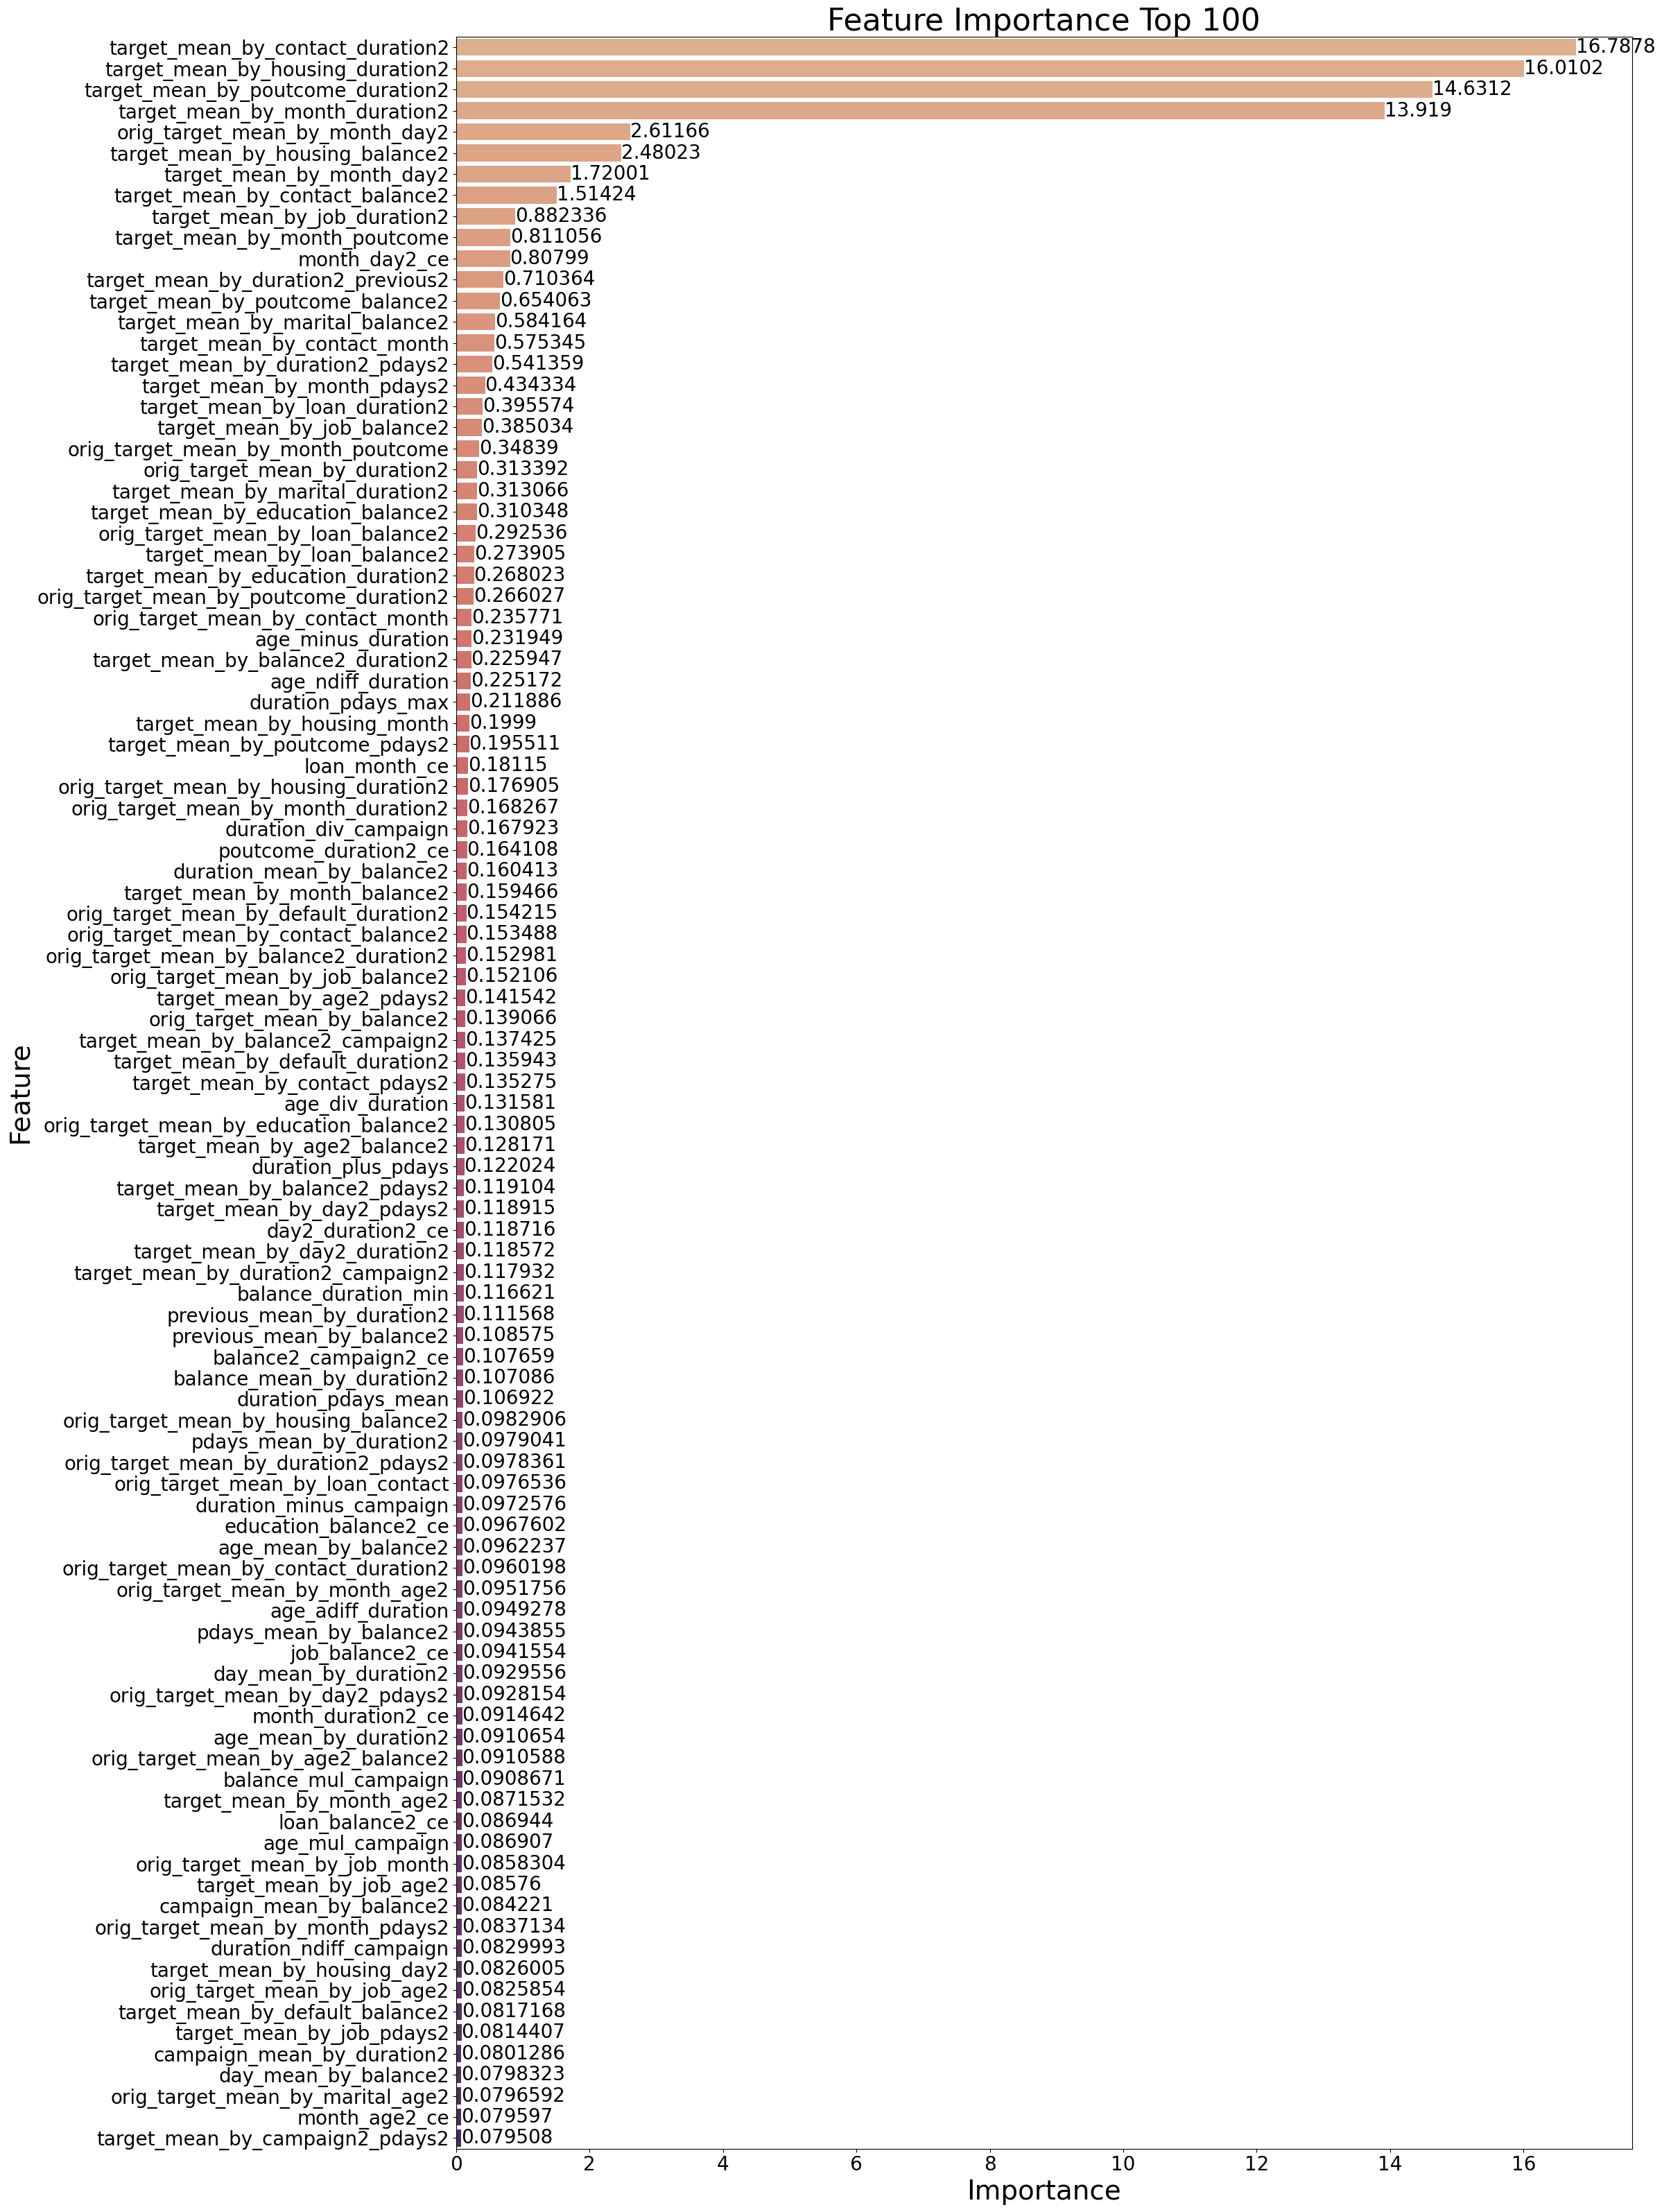

FI graph saved successfully to ../../runs/xgb-057-trl13-5fold-s42


In [7]:
df = result["fi_mean"].to_pandas().rename(columns={"mean_ratio": "Importance"})
df_top100 = df[:100]

fig, ax = plt.subplots(figsize=(24, 32))
sns.barplot(
    data=df_top100,
    y="Feature",
    x="Importance",
    orient="h",
    palette="flare",
    hue="Feature",
    ax=ax
)
for container in ax.containers:
    labels = ax.bar_label(container)
    for label in labels:
        label.set_fontsize(20)
plt.title("Feature Importance Top 100", fontsize=32)
plt.xlabel("Importance", fontsize=28)
plt.ylabel("Feature", fontsize=28)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
plt.tight_layout()

fig.savefig(run_dir / "feature_importance.png", dpi=200, bbox_inches="tight")
fig.savefig(run_dir / "feature_importance.svg", bbox_inches="tight")

plt.show()

print(f"FI graph saved successfully to {run_dir}")

## Save Important Cols

In [8]:
thresholds = [0.90, 0.95, 0.99]

# 重要度の並びを安定化（同率時はFeature名で昇順）
df = df.sort_values(["Importance", "Feature"], ascending=[False, True], ignore_index=True)

total = df["Importance"].sum()
print("Contributed cols (nonzero in df):", len(df))

keep_dict = {}
for th in thresholds:
    # この閾値でどこまで採用するか（しきい値を超える要素も1つ含める）
    limit = th * total
    cum = df["Importance"].cumsum()
    k = int((cum <= limit).sum())
    if k < len(df):
        k += 1

    keep_cols = df["Feature"].iloc[:k].tolist()
    importance = df["Importance"].iloc[:k].to_list()
    cover = float(cum.iloc[k-1] / total) if total > 0 and k > 0 else 0.0

    print(f"\nThreshold {th:.2f} → Keep {k} cols (coverage={cover:.4f})")
    keep_dict[f"{th:.2f}"] = {
        "k": k,
        "coverage": cover,
        "cols": keep_cols,
        "importance": importance
    }

# 保存
path_keep = run_dir / "keep_cols.json"
with open(path_keep, "w", encoding="utf-8") as f:
    json.dump(keep_dict, f, ensure_ascii=False, indent=4)
print(f"saved: {path_keep}")

Contributed cols (nonzero in df): 598

Threshold 0.90 → Keep 132 cols (coverage=0.9006)

Threshold 0.95 → Keep 227 cols (coverage=0.9500)

Threshold 0.99 → Keep 391 cols (coverage=0.9901)
saved: ../../runs/xgb-057-trl13-5fold-s42/keep_cols.json
